# Demo of functionalities in QAOA Utilities

This notebooks walks through some of the key features provided by `QAOA.utilities`. The methods therein fall into four categories:

* Methods for creating random graphs and Hamiltonians, and converting between the two.
* Methods for creating certain types of toy data sets (e.g. combos of separate Gaussians), which may be used e.g. for simple clustering with the QAOA.
* Methods allowing parameter sweeps to be performed, with a view to studying the landscape of the optimisation problem being tackled.
* Functions that compute analytic results for certain graphs (will use exact formulae from papers by Farhi, Hadfield, etc) to benchmark and compare against numerical results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Type, Iterable

# import the neccesary pyquil modules
from qaoa.cost_function import QAOACostFunctionOnQVM, QAOACostFunctionOnWFSim
from pyquil.api import local_qvm, WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm

# import the QAOAParameters that we want to demo
from qaoa.parameters import AdiabaticTimestepsQAOAParameters,\
AlternatingOperatorsQAOAParameters, AbstractQAOAParameters, GeneralQAOAParameters,\
QAOAParameterIterator, FourierQAOAParameters

from vqe.optimizer import scipy_optimizer
import utilities as ut

## Random Hamiltonians and graphs

The `create_random_hamiltonian` method generates a random Hamiltonian (problem instance) for a specified number of qubits. It randomly selects a number of biases and number of couplings, then assigns each of them a random value between zero and one. For instance, let's create two 4-qubit Hamiltonians.

In [2]:
h1 = ut.create_random_hamiltonian(4)
h2 = ut.create_random_hamiltonian(4)
print("h1 =",h1)
print()
print("h2 =",h2)

h1 = (0.7380680957744432+0j)*Z2 + (0.5779851080176981+0j)*Z3 + (0.35171970235338423+0j)*Z0*Z3 + (0.7241873386478982+0j)*Z1*Z2

h2 = (0.7452346171192386+0j)*Z1*Z2 + (0.1625588422499339+0j)*Z2*Z3


We can create a `networkx` graph corresponding to the qubit couplings in `h1` using the `AbstractQAOAParameters` class, together with the `create_networkx_graph` method:

In [3]:
myAbstractParams = AbstractQAOAParameters([h1,1]) # Here we have to pass in a timestep value too - can/should we clean this up?
print(myAbstractParams)

Hyperparameters:
	register: [0, 1, 2, 3]
	qubits_singles: [2, 3]
	single_qubit_coeffs: [0.7380681  0.57798511]
	qubits_pairs: [[0, 3], [1, 2]]
	pair_qubit_coeffs: [0.3517197  0.72418734]
	timesteps: 1



/home/ewan/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


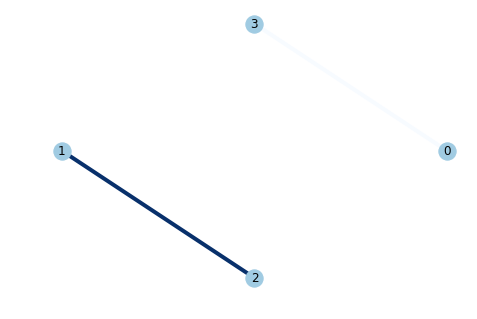

In [4]:
g1 = ut.networkx_from_hamiltonian(myAbstractParams.qubits_pairs,myAbstractParams.pair_qubit_coeffs)
ut.plot_networkx_graph(g1)

# NOTE: for some reason there is a deprecation warning here associated with Matplotlib.

We can alternatively work backwards, creating a graph first, then the corresponding Hamiltonian. Let's take the graph we have just produced (`g1`) and convert it back to its corresponding Hamiltonian, which we called `h1` above. Neglecting any missing single qubit bias terms, we see that `H1` here is the same as `h1` defined above.

In [5]:
H1 = ut.hamiltonian_from_networkx(g1)
print(H1)

(0.35171970235338423+0j)*Z0*Z3 + (0.7241873386478982+0j)*Z1*Z2


TODO - include & showcase functionality for not entirely random graphs, e.g.:

* graphs with a specified maximum node degree
* graphs with/without triangles, etc.
* Farhi's "ring of disagrees"
* Erdos-Renyi, geometric random, etc

In [6]:
# Create a graph with maximum number degree..

## Simple toy datasets for QAOA MaxCut clustering

Here we demo some of the methods for generating simple datasets for QAOA clustering problems. Let's create a data set of two clusters, where the points in each cluster follow Gaussian statistics.

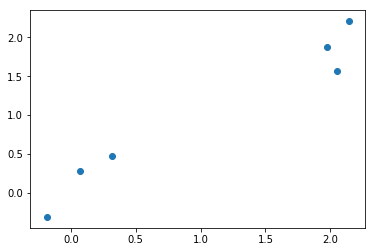

In [7]:
n_clusters = 2 # Number of clusters we want
n_points = [3,3] # Number of points in each cluster
means = [[0,0], [2,2]] # Cluster means (the [x,y] coordinates of each cluster)
variances = [[0.1,0.1],[0.1,0.1]] # The variances in the [x,y] coordinates for each of the two clusters
covs = [0,0] # For each of the two clusters, the xy covariance

myData1 = ut.create_gaussian_2Dclusters(n_clusters,n_points,means,variances,covs)
ut.plot_cluster_data(myData1)

Now let's set up the MaxCut problem. We compute the distances using `distances_dataset`, which returns a `dict` whose keys are the data point pairs, and whose values are the Euclidean distances between them

In [8]:
dists = ut.distances_dataset(myData1)
dists

{'01': 0.6376631162858049,
 '02': 0.9351794553848979,
 '03': 3.0760945950618277,
 '04': 2.921024444524626,
 '05': 3.430299170012205,
 '12': 0.3210050238571195,
 '13': 2.4917078095267082,
 '14': 2.3678528111040182,
 '15': 2.835976909758161,
 '23': 2.1707223366911266,
 '24': 2.049241974666192,
 '25': 2.515642294827084,
 '34': 0.32537582596456055,
 '35': 0.3695824246417131,
 '45': 0.6505045479985773}

In [9]:
hData = ut.hamiltonian_from_dict(dists)
print(hData)

(0.6376631162858049+0j)*Z0*Z1 + (0.9351794553848979+0j)*Z0*Z2 + (3.0760945950618277+0j)*Z0*Z3 + (2.921024444524626+0j)*Z0*Z4 + (3.430299170012205+0j)*Z0*Z5 + (0.3210050238571195+0j)*Z1*Z2 + (2.4917078095267082+0j)*Z1*Z3 + (2.3678528111040182+0j)*Z1*Z4 + (2.835976909758161+0j)*Z1*Z5 + (2.1707223366911266+0j)*Z2*Z3 + (2.049241974666192+0j)*Z2*Z4 + (2.515642294827084+0j)*Z2*Z5 + (0.32537582596456055+0j)*Z3*Z4 + (0.3695824246417131+0j)*Z3*Z5 + (0.6505045479985773+0j)*Z4*Z5


Now that we have the Hamiltonian, we can go ahead and run the QAOA to check that the points are clustered correctly. We will use the `GeneralQAOAParameters` class, and three timesteps (p=3). We don't include any single-qubit bias terms.

In [10]:
n_qubits = 6
p = 3

# Specify some angles
betas = np.random.rand(n_qubits,p)
gammas_singles = []
gammas_pairs = np.random.rand(len(dists),p)
parameters = (betas,gammas_singles,gammas_pairs)

myGeneralParams = GeneralQAOAParameters([hData,p],parameters)
print(myGeneralParams)

Hyperparameters:
	register: [0, 1, 2, 3, 4, 5]
	qubits_singles: []
	qubits_pairs: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
Parameters:
	betas: [[0.27804504 0.41009165 0.72402649], [0.47693689 0.87229186 0.76422432], [0.23583463 0.08938916 0.50151877], [0.47347742 0.82785108 0.74999014], [0.52548097 0.26100414 0.93182705], [0.55893864 0.47356003 0.50710292]]
	gammas_singles: []
	gammas_pairs: [[8.58953214e-01 1.28905258e-02 5.05147660e-01], [7.22302227e-01 6.75232520e-01 8.05617216e-01], [3.32395497e-01 9.96286385e-01 1.74284841e-01], [9.05566283e-01 3.89112038e-01 7.99989054e-01], [8.98856669e-01 3.75931285e-01 9.02350009e-02], [9.00044206e-01 5.75236645e-01 5.00036101e-01], [6.29298294e-01 7.47728760e-01 2.06368576e-01], [5.03836079e-01 2.53866731e-01 4.66880712e-01], [7.98281569e-01 3.87330794e-01 9.15970525e-01], [7.71674060e-01 9.47666456e-01 1.90448680e-02], [9.63595087e-01 4.31554128e-01 7.74964679e-0

In [11]:
# NOTE - the optimiser will reach its maximum number of iterations, but for the parameters being used here,
# the choice maxiter=100 seems to be more than sufficient to get to the optimum with high probability.

sim = WavefunctionSimulator() # Define the wavefunction simulator
cost_function = QAOACostFunctionOnWFSim(hData,
                                        params=myGeneralParams,
                                        sim=sim,
                                        return_standard_deviation=True,
                                        noisy=False,
                                        log=[])
res = scipy_optimizer(cost_function, myGeneralParams.raw(), epsilon=1e-3,
                      maxiter=100)
res

     fun: -7.903561630166031
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 100
  status: 2
 success: False
       x: array([ 1.26873060e+00,  4.09240231e-01,  7.15074020e-01,  4.69941686e-01,
        8.69585989e-01,  7.56244226e-01,  2.33560507e-01,  9.38985223e-02,
        4.95467746e-01,  4.67037959e-01,  1.82719028e+00,  1.76217972e+00,
        1.52151387e+00,  2.53434110e-01,  9.27433194e-01,  5.49885355e-01,
        4.71277351e-01,  1.50351776e+00,  1.86784301e+00, -1.90493572e-03,
        1.48212764e+00,  1.70214170e+00,  7.52245151e-01,  1.18706695e+00,
        3.19937518e-01,  9.92401184e-01,  1.17567502e+00,  8.94767206e-01,
        3.81964359e-01,  7.99549366e-01,  8.97997656e-01,  3.75019867e-01,
        1.09133899e+00,  8.99119305e-01,  5.71601030e-01,  4.99952762e-01,
        6.28904741e-01,  7.47161730e-01,  2.03686727e-01,  5.00964263e-01,
        2.51458055e-01,  4.66637952e-01,  7.94348431e-01,  3.82048926e-01,
        9.

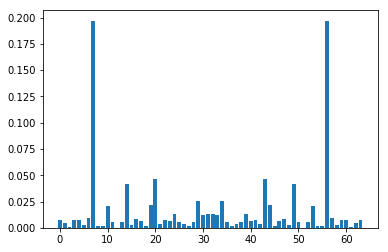

In [12]:
opt_wfn = cost_function.get_wavefunction(res.x)
probs = opt_wfn.probabilities()
plt.bar(range(len(probs)),probs)
plt.show()

Now get the string corresponding to the optimal solution. The `argmax` function will return the first of the two degenerate solutions. As expected, we find that the first three qubits are in one class, and the second three qubits in another (this is the way the data was constructed).

In [13]:
optimal_string = np.argmax(probs)
"{0:06b}".format(optimal_string)

'000111'

We can check that the other optimal solution found is the complement bitstring, i.e. 111000:

In [14]:
probs[optimal_string] = 0 # Sets the previously found optimal solution to have zero probability
optimal_string_complement = np.argmax(probs)
"{0:06b}".format(optimal_string_complement)

'111000'